## Surnjani Djoko
## Finalized Dec 5, 2021, also incorporated some of Siqi's LOO binning and business logic
## Feature imputation and Feature transformation on test dataset

# TO DO: quick review if the imputation is correct!!

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Define functions

In [2]:
# show visual count of categorical variable

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def view_categorical_count(df, var):
    
    var_count = df[var].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(var_count.index, var_count.values, alpha=0.9)
    plt.title('Frequency Distribution of {var}')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(var, fontsize=12)
    plt.show()
    
# provide quick ratio count of categorical variable
#Getting frequency count of a categorical variable and convert it into percentage
def compute_categorical_value_ratio(df, var):
    return df[var].value_counts()/df[var].count()*100

def inspect_missing_value(df):
    #Calculating percentage of missing values per column
    print(df.isna().mean().round(4) * 100)
    #df.isnull().sum()/df.shape[0]*100
    # remove columns that have more than 90% nan rows
    #df = df.loc[:,df.isnull().sum() < 0.9*df.shape[0]]
    #Get the column with the largest number of missing values
    print(df.isnull().sum().nlargest(5))
    
# check any duplicated row
#df.duplicated().any().sum()

In [3]:
# extract categorical vs. numerical columns
def find_diff_type_var(df):
    cat_var = df.loc[:,df.dtypes == np.object].columns
    num_var = df.loc[:,df.dtypes != np.object].columns
    return(cat_var, num_var)

In [4]:
# numerical correlation
def plot_pearson_correlation(df, cols, low_thres, high_thres):
    # customized
    
    corr_df = df[cols].corr()
    # Get only half portion of corr_df to avoid df, so create mask    
    mask = np.triu(np.ones_like(corr_df), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(corr_df, vmin=-1, vmax=1, cbar=False,
                     cmap='coolwarm', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if low_thres < t < high_thres:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks( size='x-large')
    plt.yticks(rotation=0, size='x-large')
    # Save fig uncomment first
    # plt.savefig("Heatmap DF")
    plt.show()
    return corr_df

# in case the table is getting too big, we can use the list that cap the threshold
def list_pearson_correlation(df, cols, low_thres, high_thres):
    '''
    low_thres ~ -0.5
    high_thres ~ 0.5
    '''
    
    corr = df[cols].corr()
    corr_list=[]
    for i in range(0, len(corr.index)):
        for j in range(0, len(corr.columns)):
            if ((corr.iloc[i,j] > high_thres or corr.iloc[i,j] < low_thres) and corr.iloc[i,j] != 1):
                corr_list.append(str(corr.index[i] + ' and ' + corr.columns[j] + ' : ' + str(round(corr.iloc[i,j], 2))))       

    corr_list = '\n'.join(corr_list)
    print(corr_list)

In [5]:
# numerical imputation using related segment with groupby
def impute_grpby(df, col, grpby, impt_fct):
    '''
    col is the column to be imputed
    grpby can be a string or list
    impt_fct provide function of imputation - mean, max, min, median, etc.
    ''' 
    #display(df.groupby(grpby,dropna=False)[col].transform(impt_fct))
    # --------- transform is for individual series????
    df[col] = df[col].fillna(df.groupby(grpby)[col].transform(impt_fct))
    return df[col]

In [6]:
# categorical imputation using WoE
# (1) calculate weight of evidence for each categorical column 
# after reviewing we can decide to use it or not
# https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

def IV_WoE(data, col, target, show_woe=True):
    
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    do = pd.DataFrame({'x': data[col],'y':data[target]})
    
    #display(do)
    d=do.groupby("x", as_index=False, dropna=False).agg({"y":['count','sum']})
    d.columns=['Category','N','Events']
    d['%N'] = d['N']/d.shape[0]
    #display(d)
    d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
    d['Non-Events'] = d['N'] - d['Events']
    d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
    d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
    d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
    d.insert(loc=0, column='Variable', value=col)
    #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
    temp =pd.DataFrame({"Variable" : [col], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
    newDF=pd.concat([newDF,temp], axis=0)
    woeDF=pd.concat([woeDF,d], axis=0)
    
    #Show WOE Table
    if show_woe == True:
        display(d)
    return newDF, woeDF

In [ ]:
# ----------- categorical feature transformation (currently not used!!!!)
# frequency encoding
def freq_encode(c, df):
    freq_count=df[c].value_counts(normalize=True).to_dict()
    c_imputed=str(c)+'_imputed'
    df[c_imputed]=df[c].map(freq_count)
    return df

# target encoding
def target_encode(c, df, target):
    '''
    target is 'LABEL'
    '''
    import category_encoders as ce
    encoder = ce.TargetEncoder(cols=target)
    encoder.fit_transform(df[target], df[c])
    return ??????

# use WOE for categorical variables - feature creation based on the output woe value
def woe_encoder(df, c,target):
    from category_encoders import WOEEncoder
    x = WOEEncoder()
    x.fit(df[c],df[target])
    df[str(c)+'_encoded']=x.transform(df[c],df[target])
    return df[[c,str(c)+'_encoded']].drop_duplicates().sort_values(by=(str(c)+'_encoded'))

## Read and review the training dataset

In [7]:
df_train = pd.read_csv('data/training_initial.csv')
print(df_train.shape)
df_train.sample(3)

(14028, 107)


,_id_x,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Exposures,Ext_agent_app_or_defer_time,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Numberinc_,Incident_Station_Area,Incident_Ward,Initial_CAD_Event_Type,Intersection,Last_TFS_Unit_Clear_Time,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Alarm_Timeinc_,TFS_Arrival_Time,TFS_Firefighter_Casualties,_id_y,ID,NAME,ADDRESS,ADDRESS_POINT_ID,ADDRESS_ID,CENTRELINE_ID,MAINT_STAGE,ADDRESS_NUMBER,LINEAR_NAME_FULL,POSTAL_CODE,GENERAL_USE,CLASS_FAMILY_DESC,ADDRESS_ID_LINK,PLACE_NAME,X,Y,LATITUDE,LONGITUDE,WARD_NAME,MUNICIPALITY_NAME,OBJECTID,geometry,fs_Longitude,fs_Latitude,Station_Area,LABEL,DISTANCE_INCIDENT_FIRESTATION,INCIDENT_DATE,DOW,IS_WEEKEND,YEAR,MONTH,MINUTES_TO_ARRIVE,TFS_ARR_DAY,TFS_ALM_DAY,TFS_ARR_HOUR,TFS_ALM_HOUR,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,INCIDENT_PERIOD_CAT,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,date,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,Incident_Numberdemo,TFS_Alarm_Timedemo,Latitude,Longitude,location,FSA,fsa_imputed,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant
6293,1951665,"25 - Washroom or Bathroom (toilet,restroom/loc...",01 - Normal (no change),8 - Not applicable (not a business),0,0,10000.0,5.0,NaN,2018-02-13 18:33:00,1 - Confined to object of origin,01 - Fire,7 - Not applicable: Occupant(s) first alerted ...,8 - Not applicable (no system),8 - Not applicable (bldg not classified by OBC...,2018-02-13 18:05:42,999 - Undetermined,F18016889,215,25.0,Fire - Residential,Centennial Rd / Pepper Tree Dr,2018-02-13 19:01:16,002,"46 - Rubbish, Trash, Waste",1 - Extinguished by fire department,18,60,99 - Undetermined,301 - Detached Dwelling,1 - Floor/suite of fire origin: No smoke alarm,98 - Not applicable: Alarm operated OR presenc...,8 - Not applicable - no smoke alarm or presenc...,7 - Not applicable: Occupant(s) first alerted ...,"7 - Spread to other floors, confined to building",8 - Not applicable - no sprinkler system present,3 - No sprinkler system,2 - Fire with no evidence from street,2018-02-13 17:55:02,2018-02-13 17:59:47,0,36,25,FIRE STATION 215,5318 LAWRENCE AVE E,354673,327448,107237,REGULAR,5318,Lawrence Ave E,NaN,Fire Station,"Land, Structure, Structure Entrance",NaN,Fire Station 215,NaN,NaN,NaN,NaN,Scarborough-Rouge Park (25),Scarborough,2250005,"{u'type': u'Point', u'coordinates': (-79.14806...",-79.148066,43.777392,215,0,13668.607412,2018-02-13 00:00:00,1,0,2018,2,4.750,13,13,17,17,61.483,5,Evening,0,0,0,0,2018-02-13,0.73,0.96,6.6,-4.98,72.245,18.715,F18016889,2018-02-13 17:55:02,43.776674,-79.146284,M1C 2B8,M1C,0,2413.45,0.041260,0.026619,42.1,44.0,0.490246,11.107533
7824,1952763,81 - Engine Area,NaN,NaN,0,0,15000.0,NaN,NaN,2016-01-08 05:30:30,NaN,01 - Fire,NaN,NaN,NaN,2016-01-08 05:40:00,81 - Vehicle - Electrical,F16002270,121,10.0,VEFH,HWY 401 / 401 C W Allen Ramp,2016-01-08 06:04:05,NaN,99 - Undetermined (formerly 98),1 - Extinguished by fire department,3,10,52 - Electrical Failure,901 - Automobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4 - Flames showing from small area (one storey...,2016-01-08 05:21:29,2016-01-08 05:28:39,0,9,7,FIRE STATION 121,10 WILLIAM CARSON CRES,4792285,416944,13971133,REGULAR,10,William Carson Cres,NaN,Fire Station,"Land, Structure, Structure Entrance",NaN,Fire Station 121,NaN,NaN,NaN,NaN,Don Valley West (15),North Y

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14028 entries, 0 to 14027
Columns: 107 entries, _id_x to min_dist_to_hydrant
dtypes: float64(29), int64(30), object(48)
memory usage: 11.5+ MB


In [9]:
inspect_missing_value(df_train)

_id_x                                                              0.00
Area_of_Origin                                                    10.89
Building_Status                                                   36.04
Business_Impact                                                   36.05
Civilian_Casualties                                                0.00
Count_of_Persons_Rescued                                           0.00
Estimated_Dollar_Loss                                             10.87
Estimated_Number_Of_Persons_Displaced                             36.04
Exposures                                                         98.13
Ext_agent_app_or_defer_time                                       10.90
Extent_Of_Fire                                                    36.05
Final_Incident_Type                                                0.00
Fire_Alarm_System_Impact_on_Evacuation                            36.05
Fire_Alarm_System_Operation                                     

In [10]:
cat_cols, num_cols = find_diff_type_var(df_train)
print(cat_cols)
print(num_cols)

Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
       'Ext_agent_app_or_defer_time', 'Extent_Of_Fire', 'Final_Incident_Type',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Fire_Under_Control_Time',
       'Ignition_Source', 'Incident_Numberinc_', 'Initial_CAD_Event_Type',
       'Intersection', 'Last_TFS_Unit_Clear_Time', 'Level_Of_Origin',
       'Material_First_Ignited', 'Method_Of_Fire_Control', 'Possible_Cause',
       'Property_Use', 'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
       'Smoke_Spread', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival',
       'TFS_Alarm_Timeinc_', 'TFS_Arrival_Time', 'NAME', 'ADDRESS',
       'MAINT_STAGE', 'LINEAR_NAME_FULL', 'POSTAL_CODE', 'GENERAL_USE',
       'CL

## Decide which columns to drop for the obvious reasons

In [11]:
# identifies columns I used and added that are not needed for prediction, and high null values, ID related ...

my_not_needed_cols = ['Station_Area', 'TFS_Alarm_Timeinc_', 'TFS_Arrival_Time',
                      'YEAR','TFS_ARR_DAY','TFS_ALM_DAY','TFS_ARR_HOUR','TFS_ALM_HOUR']
# additional numerical columns that are not needed
add_num_cols = ['Incident_Station_Area', 'Incident_Ward','ADDRESS_POINT_ID', 'ADDRESS_ID',
       'CENTRELINE_ID', 'ADDRESS_NUMBER', 'OBJECTID', 'fs_Longitude',
       'fs_Latitude', 'Latitude', 'Longitude']
add_cat_cols = ['Intersection', 'Last_TFS_Unit_Clear_Time','TFS_Alarm_Timeinc_', 
        'TFS_Arrival_Time', 'NAME', 'ADDRESS','LINEAR_NAME_FULL', 'PLACE_NAME', 
        'WARD_NAME', 'MUNICIPALITY_NAME', 'geometry','INCIDENT_DATE',
                'Ext_agent_app_or_defer_time','Fire_Under_Control_Time','location']

fire_not_needed_cols = ['_id_x','_id_y','Exposures']
    #Exposure has more than 90% missing
#Demographics_not_needed_cols = ['fsa_imputed','location','FSA'] 
Demographics_not_needed_cols = ['fsa_imputed','location']  
station_not_needed_cols=['ID', 'ADDRESS_ID_LINK', 'X','Y', 'LATITUDE', 'LONGITUDE','POSTAL_CODE','MAINT_STAGE','GENERAL_USE','CLASS_FAMILY_DESC', 'INCIDENT_PERIOD_CAT']
weather_not_needed_cols=['date', 'Incident_Numberdemo','TFS_Alarm_Timedemo']
drop_columns = my_not_needed_cols + add_num_cols + add_cat_cols + Demographics_not_needed_cols + \
    fire_not_needed_cols + station_not_needed_cols + weather_not_needed_cols
df_train.drop(columns=drop_columns, axis=1,inplace=True)
df_train.shape

(14028, 57)

In [12]:
# review after the drop!!
cat_cols, num_cols = find_diff_type_var(df_train)
print(cat_cols)
print(num_cols)

Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
       'Extent_Of_Fire', 'Final_Incident_Type',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Ignition_Source', 'Incident_Numberinc_',
       'Initial_CAD_Event_Type', 'Level_Of_Origin', 'Material_First_Ignited',
       'Method_Of_Fire_Control', 'Possible_Cause', 'Property_Use',
       'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
       'Smoke_Spread', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'FSA'],
      dtype='object')
Index(['Civilian_Casualties', 'Count_of_Persons_Rescued',
       'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
       'Number_of_responding_apparatus', 'Number_of_responding_personnel',
       'TFS_Firefighter

## Numerical features

In [13]:
inspect_missing_value(df_train[num_cols])
# only four variables need to be imputed!!
# only one sample of DISTANCE_INCIDENT_FIRESTATION and min_dist_to_hydrant is missing

Civilian_Casualties                       0.00
Count_of_Persons_Rescued                  0.00
Estimated_Dollar_Loss                    10.87
Estimated_Number_Of_Persons_Displaced    36.04
Number_of_responding_apparatus            0.00
Number_of_responding_personnel            0.00
TFS_Firefighter_Casualties                0.00
LABEL                                     0.00
DISTANCE_INCIDENT_FIRESTATION             0.01
DOW                                       0.00
IS_WEEKEND                                0.00
MONTH                                     0.00
MINUTES_TO_ARRIVE                         0.00
MINUTES_TO_LEAVE                          0.00
INCIDENT_PERIOD_NUM                       0.00
IS_HOLIDAY                                0.00
IS_HOLIDAY_LAG1                           0.00
IS_HOLIDAY_LEAD1                          0.00
IS_HOLIDAY_SEASON                         0.00
rain_v                                    0.00
snow_v                                    0.00
snow_on_groun

In [14]:
df_train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Civilian_Casualties,14028.0,0.074636,0.382371,0.000000,0.000000,0.000000,0.000000,1.500000e+01
Count_of_Persons_Rescued,14028.0,0.037995,0.480663,0.000000,0.000000,0.000000,0.000000,2.800000e+01
Estimated_Dollar_Loss,12503.0,35138.922978,494848.544021,0.000000,300.000000,3000.000000,15000.000000,5.000000e+07
Estimated_Number_Of_Persons_Displaced,8972.0,17.429224,119.538258,0.000000,0.000000,0.000000,1.000000,9.990000e+02
Number_of_responding_apparatus,14028.0,6.843812,7.595887,1.000000,2.000000,6.000000,8.000000,4.360000e+02
Number_of_responding_personnel,14028.0,22.684274,23.305315,1.000000,8.000000,21.000000,26.000000,1.275000e+03
TFS_Firefighter_Casualties,14028.0,0.014328,0.147728,0.000000,0.000000,0.000000,0.000000,4.000000e+00
LABEL,14028.0,0.055817,0.229576,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DISTANCE_INCIDENT_FIRESTATION,14027.0,13689.550273,11.016727,13667.174802,13680.903273,13687.956063,13697.712991,1.371897e+04
DOW,14028.0,3.043627,2.008844,0.000000,1.000000,3.000000,5.000000,6.000000e+00


## (1) impute 'Estimated_Number_Of_Persons_Displaced'

In [15]:
# review estimated number of persons displaced
df_train.Estimated_Number_Of_Persons_Displaced.describe()

count    8972.000000
mean       17.429224
std       119.538258
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       999.000000
Name: Estimated_Number_Of_Persons_Displaced, dtype: float64

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Estimated_Number_Of_Persons_Displaced', ylabel='Density'>

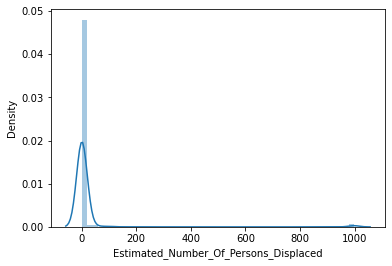

In [16]:
sns.distplot(df_train.Estimated_Number_Of_Persons_Displaced)

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Estimated_Number_Of_Persons_Displaced'>

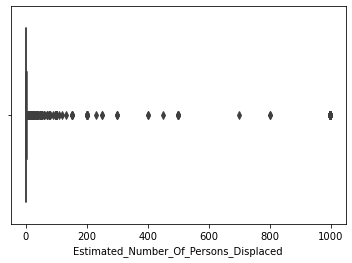

In [17]:
sns.boxplot(df_train.Estimated_Number_Of_Persons_Displaced)

In [18]:
# This is imputed based on the count_of_persons_rescued + Civilian_Casualties
col = 'Estimated_Number_Of_Persons_Displaced'
df_train[col+'_imputed'] = df_train[col]
grpby = ['Count_of_Persons_Rescued','Civilian_Casualties']
df_train[col+'_imputed'] = df_train[col+'_imputed'].fillna(df_train.groupby(grpby)[col].transform('mean').round(0))

In [19]:
# save the training imputation
est_n_person_displaced_mean_df = df_train.groupby(grpby)['Estimated_Number_Of_Persons_Displaced'].mean().\
        round(0).to_frame().reset_index().\
        rename(columns={'Estimated_Number_Of_Persons_Displaced':'Estimated_Number_Of_Persons_Displaced_mean'})
#est_n_person_displaced_mean_df['Estimated_Number_Of_Persons_Displaced_mean']
print(est_n_person_displaced_mean_df.shape)
display(est_n_person_displaced_mean_df.sample(3))
est_n_person_displaced_mean_df.to_csv('imputation/est_n_person_displaced_mean_df.csv', index=False)

(38, 3)


,Count_of_Persons_Rescued,Civilian_Casualties,Estimated_Number_Of_Persons_Displaced_mean
4,0,4,224.0
20,3,5,7.0
36,20,0,NaN


In [20]:
# review what is impacted after imputation .....
# review estimated number of persons displaced
df_train.Estimated_Number_Of_Persons_Displaced_imputed.describe()

count    14026.000000
mean        17.302367
std         95.626224
min          0.000000
25%          0.000000
50%          2.000000
75%         17.000000
max        999.000000
Name: Estimated_Number_Of_Persons_Displaced_imputed, dtype: float64

In [21]:
# confirm if there is still null value
df_train[['Estimated_Number_Of_Persons_Displaced_imputed']].isnull().sum()

Estimated_Number_Of_Persons_Displaced_imputed    2
dtype: int64

In [22]:
# confirm if there is still null value
df_train['Estimated_Number_Of_Persons_Displaced_imputed'].isnull().sum()

2

In [23]:
df_train[df_train.Estimated_Number_Of_Persons_Displaced_imputed.isnull()]

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,FSA,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant,Estimated_Number_Of_Persons_Displaced_imputed
5239,81 - Engine Area,NaN,NaN,0,20,100000.0,NaN,NaN,01 - Fire,NaN,NaN,NaN,999 - Undetermined,F18112239,Vehicle Fire,NaN,99 - Undetermined (formerly 98),1 - Extinguished by fire department,1,4,"98 - Unintentional, cause undetermined","902 - Small Truck (eg. pick-up, van, etc.)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",0,0,13678.378307,4,0,10,9.65,42.550,2,0,0,0,0,2.29,0.0,0.0,9.405,73.77,16.015,M1B,1764.25,0.055844,0.275266,38.9,38.2,0.478369,12.330654,NaN
6184,89 - Other Vehicle Area,NaN,NaN,0,14,0.0,NaN,NaN,01 - Fire,NaN,NaN,NaN,82 - Vehicle - Mechanical,F18101443,Vehicle Fire,NaN,99 - Undetermined (formerly 98),3 - Extinguished by occupant,1,4,"60 - Other unintentional cause, not classified",907 - Emergency Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 - Fire extinguished prior to arrival,0,0,13696.740280,4,0,9,6.15,10.867,5,0,0,0,0,2.25,0.0,0.0,15.630,71.51,14.270,M6M,4822.54,0.091022,0.125935,39.2,38.7,0.470658,20.538201,NaN


In [24]:
# further imputation on those not matching the groupby
df_train['Estimated_Number_Of_Persons_Displaced_imputed'].\
    fillna(df_train['Count_of_Persons_Rescued'],inplace=True)

In [25]:
# check if it is imputed correctly!!
df_train.iloc[[5239,6184]]

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,FSA,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant,Estimated_Number_Of_Persons_Displaced_imputed
5239,81 - Engine Area,NaN,NaN,0,20,100000.0,NaN,NaN,01 - Fire,NaN,NaN,NaN,999 - Undetermined,F18112239,Vehicle Fire,NaN,99 - Undetermined (formerly 98),1 - Extinguished by fire department,1,4,"98 - Unintentional, cause undetermined","902 - Small Truck (eg. pick-up, van, etc.)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7 - Fully involved (total structure, vehicle, ...",0,0,13678.378307,4,0,10,9.65,42.550,2,0,0,0,0,2.29,0.0,0.0,9.405,73.77,16.015,M1B,1764.25,0.055844,0.275266,38.9,38.2,0.478369,12.330654,20.0
6184,89 - Other Vehicle Area,NaN,NaN,0,14,0.0,NaN,NaN,01 - Fire,NaN,NaN,NaN,82 - Vehicle - Mechanical,F18101443,Vehicle Fire,NaN,99 - Undetermined (formerly 98),3 - Extinguished by occupant,1,4,"60 - Other unintentional cause, not classified",907 - Emergency Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 - Fire extinguished prior to arrival,0,0,13696.740280,4,0,9,6.15,10.867,5,0,0,0,0,2.25,0.0,0.0,15.630,71.51,14.270,M6M,4822.54,0.091022,0.125935,39.2,38.7,0.470658,20.538201,14.0


/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Estimated_Number_Of_Persons_Displaced_imputed'>

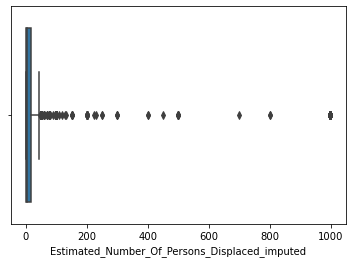

In [26]:
sns.boxplot(df_train.Estimated_Number_Of_Persons_Displaced_imputed)

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Estimated_Number_Of_Persons_Displaced_imputed', ylabel='Density'>

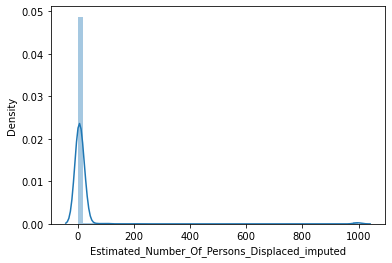

In [27]:
sns.distplot(df_train.Estimated_Number_Of_Persons_Displaced_imputed)

###  Conclusion

## (2) impute 'min_dist_to_hydrant'

In [28]:
df_train.min_dist_to_hydrant.describe()

count    14027.000000
mean        38.946958
std         88.924384
min          3.313270
25%         17.770038
50%         26.056944
75%         40.356372
max       2525.411819
Name: min_dist_to_hydrant, dtype: float64

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='min_dist_to_hydrant'>

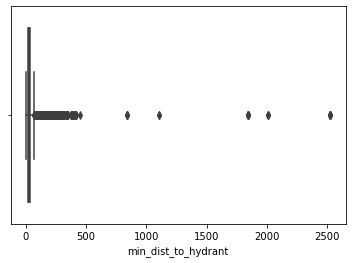

In [29]:
sns.boxplot(df_train.min_dist_to_hydrant)

In [30]:
df_train[df_train.min_dist_to_hydrant.isnull()]

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,FSA,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant,Estimated_Number_Of_Persons_Displaced_imputed
9647,81 - Engine Area,NaN,NaN,0,0,3000.0,NaN,NaN,01 - Fire,NaN,NaN,NaN,81 - Vehicle - Electrical,F11126605,VEFH,NaN,99 - Undetermined (formerly 98),1 - Extinguished by fire department,3,10,51 - Mechanical Failure,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,0,0,NaN,0,0,9,5.8,34.0,6,0,0,0,0,2.37,0.0,0.0,13.83,73.02,14.45,M1C,2413.45,0.04126,0.026619,42.1,44.0,0.490246,NaN,17.0


In [31]:
col = 'min_dist_to_hydrant'
df_train[col+'_imputed'] = df_train[col]
grpby = ['FSA']
df_train[col+'_imputed'] = df_train[col+'_imputed'].fillna(df_train.groupby(grpby)[col].transform('mean'))

In [32]:
# save the training imputation
min_dist_to_hydrant_mean_df = df_train.groupby(grpby)[col].mean().to_frame().reset_index().\
        rename(columns={col:'MIN_DIST_TO_HYDRANT_mean'})
print(min_dist_to_hydrant_mean_df.shape)
display(min_dist_to_hydrant_mean_df.sample(3))
min_dist_to_hydrant_mean_df.to_csv('imputation/min_dist_to_hydrant_mean_df.csv', index=False)

(96, 2)


,FSA,MIN_DIST_TO_HYDRANT_mean
77,M6N,27.115345
34,M4A,38.224717
54,M5B,20.086546


In [33]:
# check if it is imputed correctly!!
df_train.iloc[[9647]]

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,FSA,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant,Estimated_Number_Of_Persons_Displaced_imputed,min_dist_to_hydrant_imputed
9647,81 - Engine Area,NaN,NaN,0,0,3000.0,NaN,NaN,01 - Fire,NaN,NaN,NaN,81 - Vehicle - Electrical,F11126605,VEFH,NaN,99 - Undetermined (formerly 98),1 - Extinguished by fire department,3,10,51 - Mechanical Failure,"896 - Sidewalk, street, roadway, highway, hwy ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,0,0,NaN,0,0,9,5.8,34.0,6,0,0,0,0,2.37,0.0,0.0,13.83,73.02,14.45,M1C,2413.45,0.04126,0.026619,42.1,44.0,0.490246,NaN,17.0,34.860422


### Conclusion

This is imputed based on FSA and save in in_dist_to_hydrant_mean_df.csv

## (3) impute 'DISTANCE_INCIDENT_FIRESTATION'

In [34]:
df_train.DISTANCE_INCIDENT_FIRESTATION.describe()

count    14027.000000
mean     13689.550273
std         11.016727
min      13667.174802
25%      13680.903273
50%      13687.956063
75%      13697.712991
max      13718.968134
Name: DISTANCE_INCIDENT_FIRESTATION, dtype: float64

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DISTANCE_INCIDENT_FIRESTATION'>

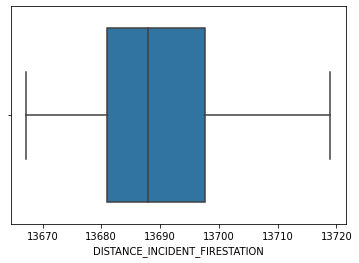

In [35]:
sns.boxplot(df_train.DISTANCE_INCIDENT_FIRESTATION)

In [36]:
col = 'DISTANCE_INCIDENT_FIRESTATION'
df_train[col+'_imputed'] = df_train[col]
grpby = ['FSA']
df_train[col+'_imputed'] = df_train[col+'_imputed'].fillna(df_train.groupby(grpby)[col].transform('mean'))

In [37]:
# save the training imputation
dist_inc_fs_mean_df = df_train.groupby(grpby)[col].mean().\
        round(0).to_frame().reset_index().\
        rename(columns={col:'DISTANCE_INCIDENT_FIRESTATION_mean'})
print(dist_inc_fs_mean_df.shape)
display(dist_inc_fs_mean_df.sample(3))
dist_inc_fs_mean_df.to_csv('imputation/dist_inc_fs_mean_df.csv', index=False)

(96, 2)


,FSA,DISTANCE_INCIDENT_FIRESTATION_mean
72,M6H,13688.0
32,M3M,13702.0
5,M1J,13675.0


In [38]:
df_train.DISTANCE_INCIDENT_FIRESTATION_imputed.describe()

count    14028.000000
mean     13689.549045
std         11.017294
min      13667.174802
25%      13680.902418
50%      13687.950305
75%      13697.711746
max      13718.968134
Name: DISTANCE_INCIDENT_FIRESTATION_imputed, dtype: float64

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DISTANCE_INCIDENT_FIRESTATION_imputed'>

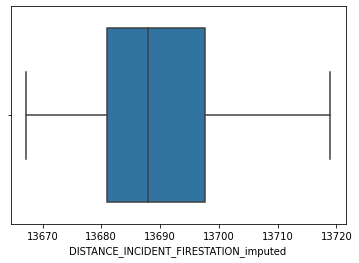

In [39]:
sns.boxplot(df_train.DISTANCE_INCIDENT_FIRESTATION_imputed)

### Conclusion

In [40]:
df_train[['DISTANCE_INCIDENT_FIRESTATION_imputed',
        'Estimated_Number_Of_Persons_Displaced_imputed','DISTANCE_INCIDENT_FIRESTATION_imputed']].isnull().sum()

DISTANCE_INCIDENT_FIRESTATION_imputed            0
Estimated_Number_Of_Persons_Displaced_imputed    0
DISTANCE_INCIDENT_FIRESTATION_imputed            0
dtype: int64

## (4) impute 'Estimated_Dollar_Loss' (however, this depends on other categorical feature, hence the categorical is imputed prior

In [41]:
# review estimated dollar loss
df_train.Estimated_Dollar_Loss.describe()

count    1.250300e+04
mean     3.513892e+04
std      4.948485e+05
min      0.000000e+00
25%      3.000000e+02
50%      3.000000e+03
75%      1.500000e+04
max      5.000000e+07
Name: Estimated_Dollar_Loss, dtype: float64

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Estimated_Dollar_Loss'>

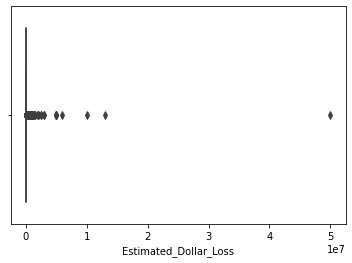

In [42]:
sns.boxplot(df_train.Estimated_Dollar_Loss)

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Estimated_Dollar_Loss', ylabel='Density'>

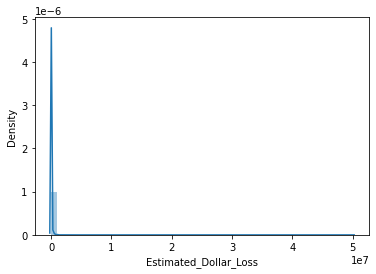

In [43]:
sns.distplot(df_train.Estimated_Dollar_Loss)

In [44]:
df_train[df_train.Property_Use.isnull()]

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,FSA,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant,Estimated_Number_Of_Persons_Displaced_imputed,min_dist_to_hydrant_imputed,DISTANCE_INCIDENT_FIRESTATION_imputed
864,79 - Other Outside Area,NaN,NaN,0,0,NaN,NaN,NaN,01 - Fire,NaN,NaN,NaN,999 - Undetermined,F13029095,FAHR,NaN,"31 - Mattress, Pillow",1 - Extinguished by fire department,5,18,99 - Undetermined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,0,0,13701.458324,2,0,4,6.117,11.233,6,0,0,0,0,2.32,0.06,0.0,7.515,64.51,17.19,M9N,4928.6,0.09292,0.117502,39.3,39.0,0.472981,27.991774,17.0,27.991774,13701.458324


In [45]:
#grpby = ['fsa_imputed', 'Property_Use','Building_Status','Business_Impact','Extent_Of_Fire']
# Building status, business impact, extent of fire: they all missings at the same rate
# Property use has much lesser missing value, go ahead impute property use first!!
# we will just use fsa_imputed + Property use group to impute for simplicity
# find the highest frequency for the fsa_imputed


# create highest freq table of property use for each FSA
freq_cat_pd = df_train.groupby('FSA')['Property_Use'].apply(lambda x: x.value_counts().index[0]).reset_index()
display(freq_cat_pd.shape)
display(freq_cat_pd.sample(3))
# save the imputation table
freq_cat_pd.to_csv('imputation/Property_Use_freq.csv',index=False)
# convert to dictionary
freq_cat_dict = dict(zip(freq_cat_pd.FSA, freq_cat_pd.Property_Use))

# create new imputed column
df_train['Property_Use_imputed'] = df_train['Property_Use']
grpby = 'FSA'
df_train['Property_Use_imputed'].fillna(df_train[grpby].map(freq_cat_dict), inplace=True)

(96, 2)

,FSA,Property_Use
24,M2R,323 - Multi-Unit Dwelling - Over 12 Units
36,M4C,323 - Multi-Unit Dwelling - Over 12 Units
27,M3C,323 - Multi-Unit Dwelling - Over 12 Units


In [46]:
df_train.iloc[[864]]

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Numberinc_,Initial_CAD_Event_Type,Level_Of_Origin,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,DISTANCE_INCIDENT_FIRESTATION,DOW,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,FSA,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,min_dist_to_hydrant,Estimated_Number_Of_Persons_Displaced_imputed,min_dist_to_hydrant_imputed,DISTANCE_INCIDENT_FIRESTATION_imputed,Property_Use_imputed
864,79 - Other Outside Area,NaN,NaN,0,0,NaN,NaN,NaN,01 - Fire,NaN,NaN,NaN,999 - Undetermined,F13029095,FAHR,NaN,"31 - Mattress, Pillow",1 - Extinguished by fire department,5,18,99 - Undetermined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 - Fire with smoke showing only - including v...,0,0,13701.458324,2,0,4,6.117,11.233,6,0,0,0,0,2.32,0.06,0.0,7.515,64.51,17.19,M9N,4928.6,0.09292,0.117502,39.3,39.0,0.472981,27.991774,17.0,27.991774,13701.458324,323 - Multi-Unit Dwelling - Over 12 Units


In [47]:
# after property use is imputed, we can now go ahead with the estimated dollar loss
col = 'Estimated_Dollar_Loss'
grpby = ['FSA', 'Property_Use_imputed']
df_train[col+'_imputed'] = df_train[col]
df_train[col+'_imputed'] = df_train[col+'_imputed'].fillna(df_train.groupby(grpby)[col].transform('mean'))

In [48]:
# save the training imputation
est_dollar_loss_mean_df = df_train.groupby(grpby)[col].mean().\
        to_frame().reset_index().\
        rename(columns={col:'Estimated_Dollar_Loss_mean'})
print(est_dollar_loss_mean_df.shape)
display(est_dollar_loss_mean_df.sample(3))
est_dollar_loss_mean_df.to_csv('imputation/est_dollar_loss_mean.csv',index=False)

(3312, 3)


,FSA,Property_Use_imputed,Estimated_Dollar_Loss_mean
2659,M6R,301 - Detached Dwelling,29175.0
3218,M9V,901 - Automobile,11330.0
2540,M6M,891 - Outdoor general auto parking,4000.0


In [49]:
# Review if all rows are imputed 
inspect_missing_value(df_train[['Estimated_Dollar_Loss_imputed',
                      'Estimated_Dollar_Loss']])

Estimated_Dollar_Loss_imputed     2.54
Estimated_Dollar_Loss            10.87
dtype: float64
Estimated_Dollar_Loss            1525
Estimated_Dollar_Loss_imputed     356
dtype: int64


In [50]:
# it is not perfect, we still have remaining missing due to groupby not matching, impute the rest with mean
est_dollar_loss_mean = df_train['Estimated_Dollar_Loss_imputed'].mean()
print(est_dollar_loss_mean)
df_train['Estimated_Dollar_Loss_imputed'] = \
       df_train['Estimated_Dollar_Loss_imputed'].fillna(df_train['Estimated_Dollar_Loss_imputed'].mean()) 

33495.76328719448


In [51]:
# review what is impacted after imputation .....
df_train.Estimated_Dollar_Loss_imputed.describe()

count    1.402800e+04
mean     3.349576e+04
std      4.677562e+05
min      0.000000e+00
25%      3.000000e+02
50%      3.833333e+03
75%      1.500000e+04
max      5.000000e+07
Name: Estimated_Dollar_Loss_imputed, dtype: float64

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Estimated_Dollar_Loss_imputed'>

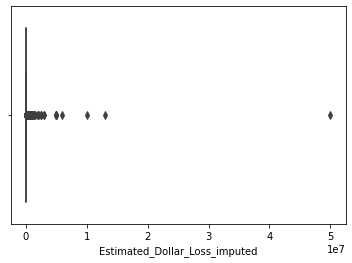

In [52]:
sns.boxplot(df_train.Estimated_Dollar_Loss_imputed)

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Estimated_Dollar_Loss_imputed', ylabel='Density'>

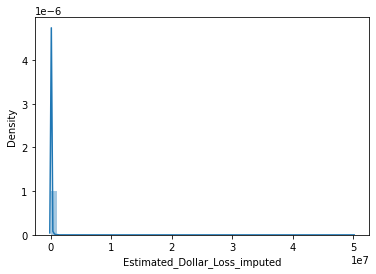

In [53]:
sns.distplot(df_train.Estimated_Dollar_Loss_imputed)

### Conclusion

In [54]:
cat_cols, num_cols = find_diff_type_var(df_train)
print(cat_cols)
print(num_cols)

Index(['Area_of_Origin', 'Building_Status', 'Business_Impact',
       'Extent_Of_Fire', 'Final_Incident_Type',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Ignition_Source', 'Incident_Numberinc_',
       'Initial_CAD_Event_Type', 'Level_Of_Origin', 'Material_First_Ignited',
       'Method_Of_Fire_Control', 'Possible_Cause', 'Property_Use',
       'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
       'Smoke_Spread', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'FSA',
       'Property_Use_imputed'],
      dtype='object')
Index(['Civilian_Casualties', 'Count_of_Persons_Rescued',
       'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
       'Number_of_responding_apparatus', 'Number_of_responding_pers

In [55]:
inspect_missing_value(df_train)
# the four variables are now imputed!!

Area_of_Origin                                                   10.89
Building_Status                                                  36.04
Business_Impact                                                  36.05
Civilian_Casualties                                               0.00
Count_of_Persons_Rescued                                          0.00
Estimated_Dollar_Loss                                            10.87
Estimated_Number_Of_Persons_Displaced                            36.04
Extent_Of_Fire                                                   36.05
Final_Incident_Type                                               0.00
Fire_Alarm_System_Impact_on_Evacuation                           36.05
Fire_Alarm_System_Operation                                      36.05
Fire_Alarm_System_Presence                                       36.05
Ignition_Source                                                  10.89
Incident_Numberinc_                                               0.00
Initia

## Categorical features

In [56]:
n_cat = [df_train[x].unique().shape[0] for x in cat_cols]
n_missing=[df_train[x].isnull().sum() for x in cat_cols]

In [57]:
cat_var_summary=pd.DataFrame(data=zip(n_cat,n_missing),index=cat_cols, 
          columns=['number of categories','number of missing records']).sort_values(by=['number of categories',
                                                    'number of missing records'], ascending=False)

In [58]:
cat_var_summary

,number of categories,number of missing records
Incident_Numberinc_,14028,0
Property_Use,276,1
Property_Use_imputed,275,0
Initial_CAD_Event_Type,109,0
FSA,96,0
Ignition_Source,85,1528
Area_of_Origin,74,1528
Level_Of_Origin,58,5057
Material_First_Ignited,55,1528
Possible_Cause,25,1528


In [59]:
high_cat=cat_var_summary[cat_var_summary['number of categories']>=20]
med_cat=cat_var_summary[(cat_var_summary['number of categories']>5) & (cat_var_summary['number of categories']<20)]
low_cat=cat_var_summary[cat_var_summary['number of categories']<=5]
#'Incident_Numberinc_' unique key 
cat_var_id=['Incident_Numberinc_']
high_cat=[x for x in high_cat.index if x not in cat_var_id]

In [60]:
# explore different variables
def exploration_cat(c, df):

    print('---------------------------------------')

    print('variable name:', c, '\n')
    print('number of categories: ' ,df[c].unique().shape[0], '\n')
    print(df[c].value_counts(normalize=True, dropna=False))

    print('---------------------------------------')

# plot categorical variables
def plot_cat(c, df):
    plt.figure(figsize=(20,7))
    cat_count=df[c].value_counts(normalize=True) ##dropna=False)
    fig=sns.barplot(100*cat_count.values[0:11], cat_count.index[0:11], alpha=0.9)
    plt.title('Frequency Distribution of ' + str(c))
    plt.xlabel('% occurences', fontsize=12)
    #fig.set_yticklabels(fig.get_yticklabels(),rotation=45, horizontalalignment='right')
    plt.show()

In [61]:
for c in high_cat:
    exploration_cat(c, df_train)

---------------------------------------
variable name: Property_Use 

number of categories:  276 

323 - Multi-Unit Dwelling - Over 12 Units                                        0.220202
301 - Detached Dwelling                                                          0.141788
901 - Automobile                                                                 0.083333
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    0.053393
302 - Semi-Detached Dwelling                                                     0.044696
848 - Trash/Rubbish/Garbage Container or Dumpster                                0.041417
303 - Attached Dwelling (eg. rowhouse, townhouse, etc.)                          0.034645
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      0.027089
902 - Small Truck (eg. pick-up, van, etc.)                                       0.022170
331 - Apartment, Flat, Tenement with Business                                    0.016111
3

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


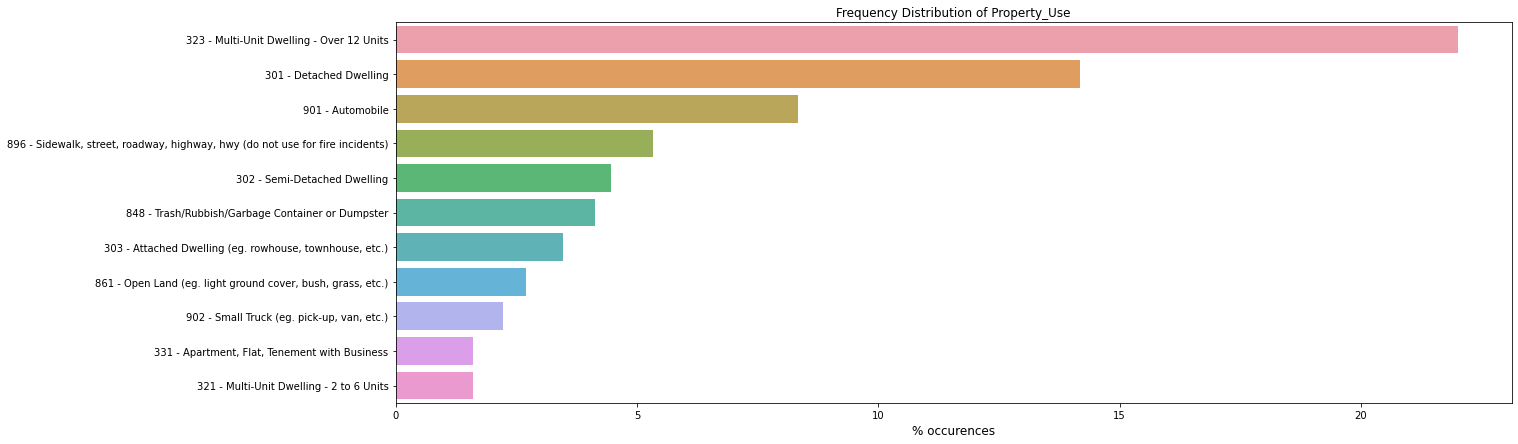

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


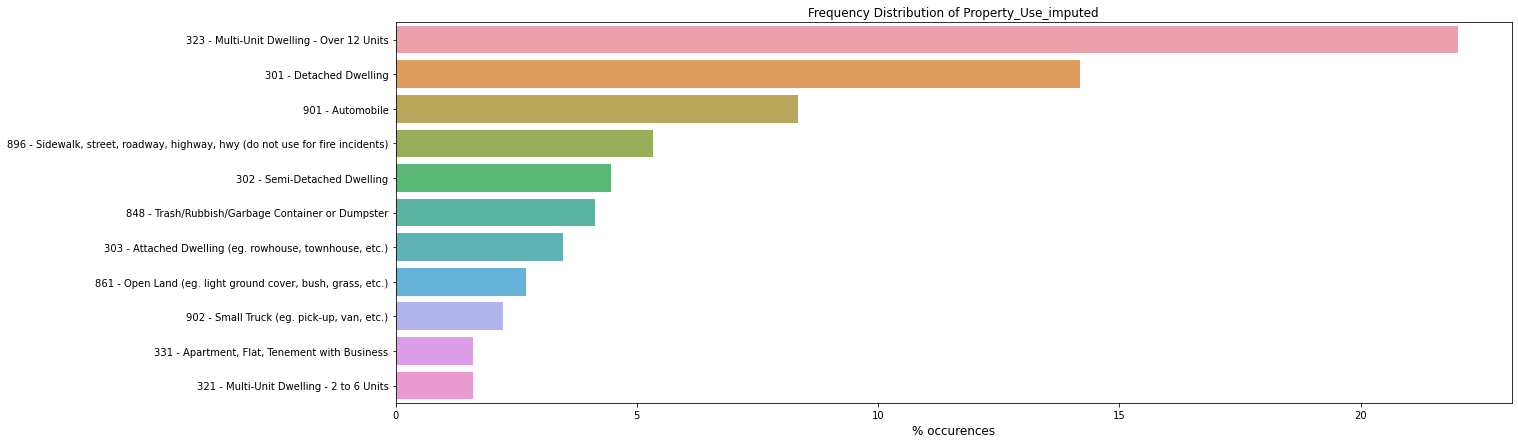

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


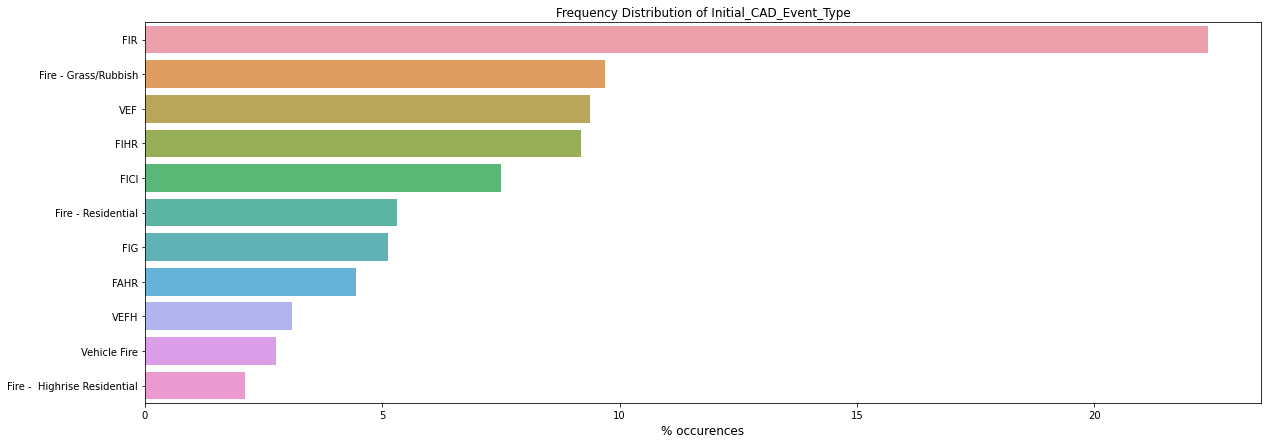

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


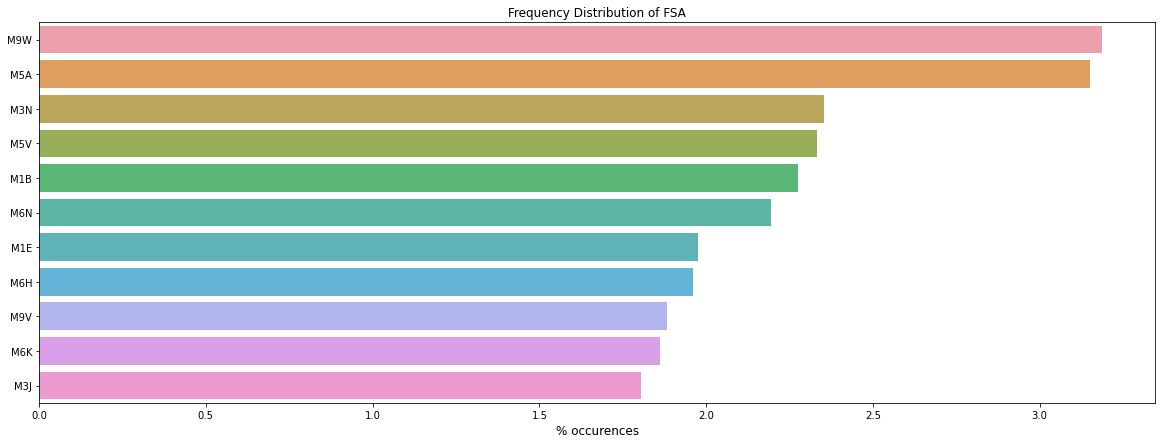

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


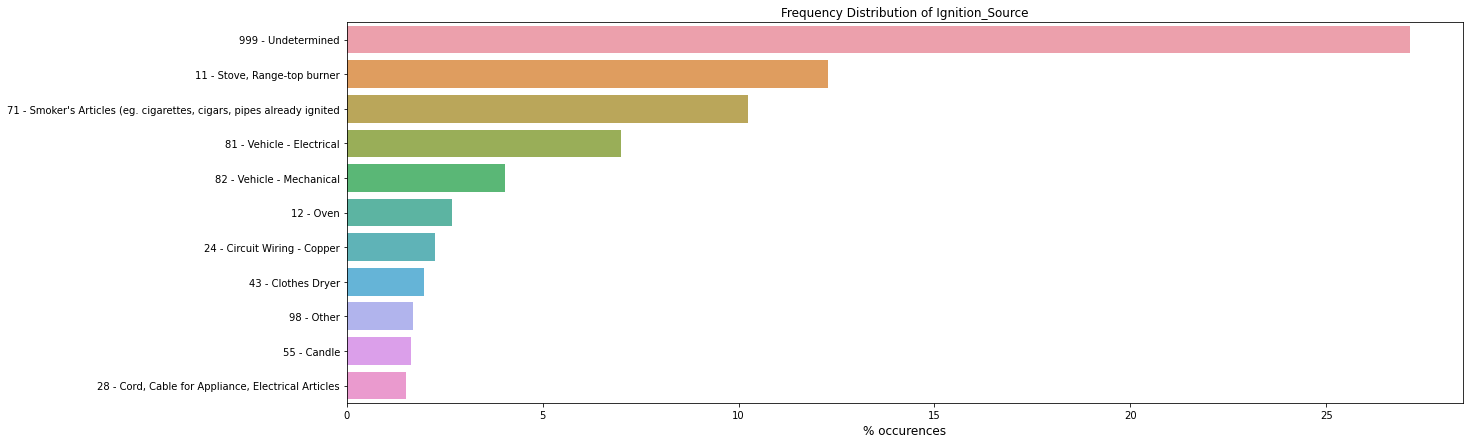

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


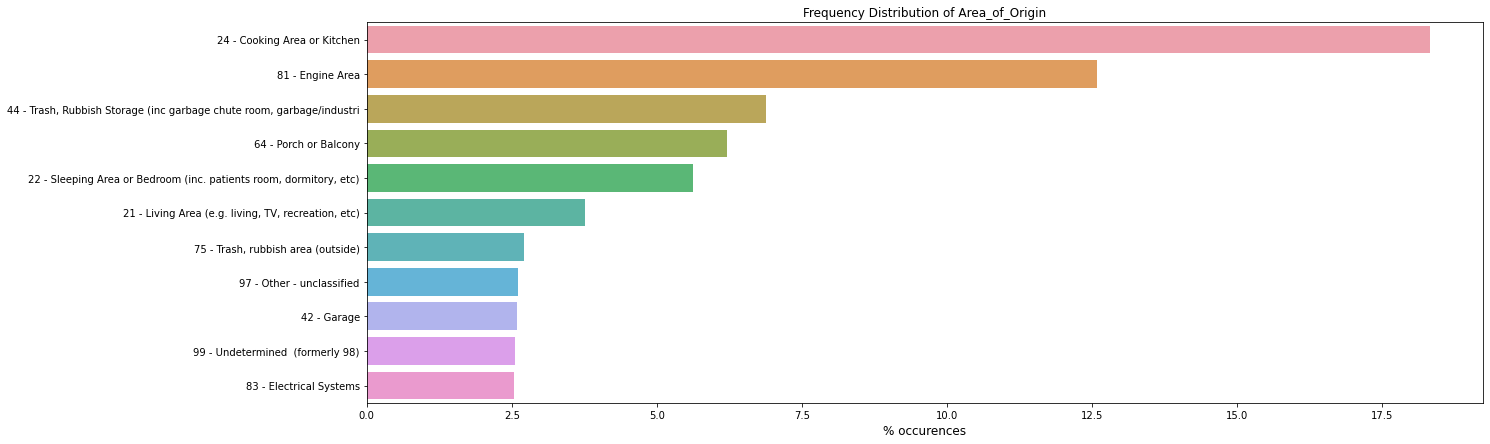

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


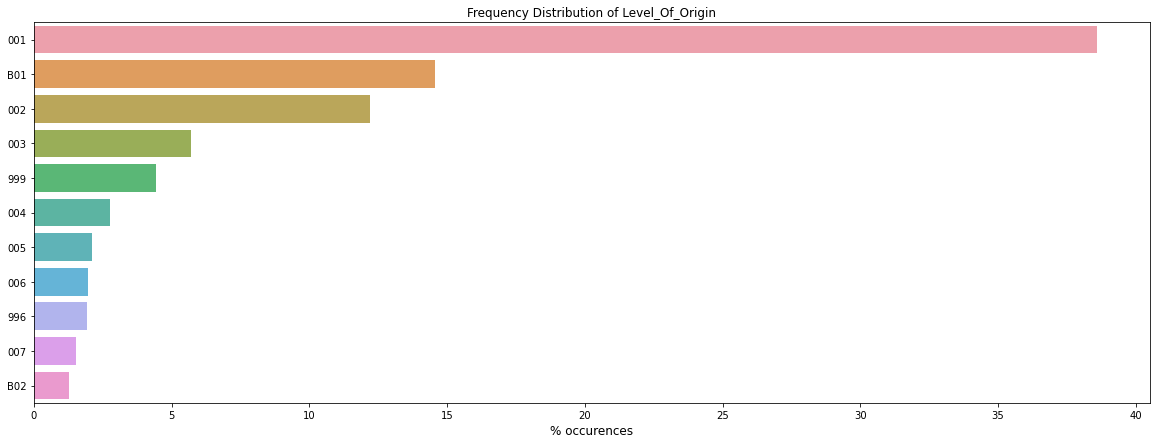

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


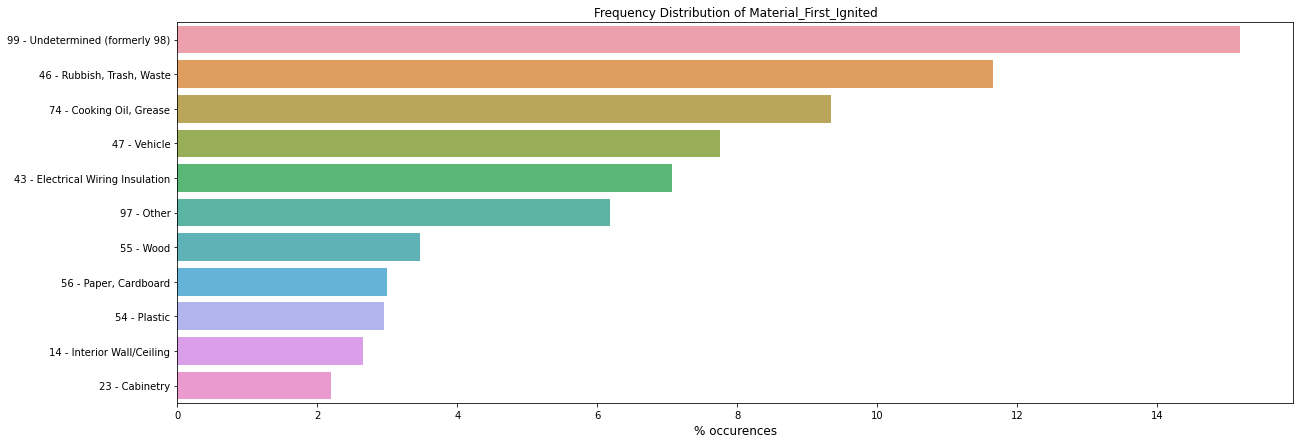

/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


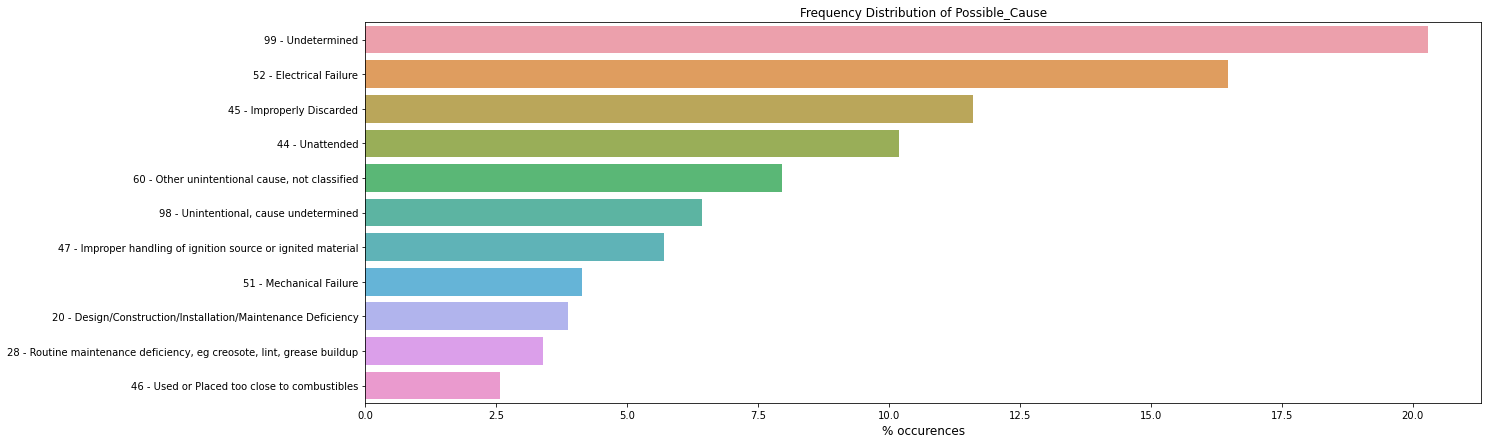

In [62]:
for c in high_cat:
    plot_cat(c, df_train)

In [63]:
inspect_missing_value(df_train[cat_cols])

Area_of_Origin                                                   10.89
Building_Status                                                  36.04
Business_Impact                                                  36.05
Extent_Of_Fire                                                   36.05
Final_Incident_Type                                               0.00
Fire_Alarm_System_Impact_on_Evacuation                           36.05
Fire_Alarm_System_Operation                                      36.05
Fire_Alarm_System_Presence                                       36.05
Ignition_Source                                                  10.89
Incident_Numberinc_                                               0.00
Initial_CAD_Event_Type                                            0.00
Level_Of_Origin                                                  36.05
Material_First_Ignited                                           10.89
Method_Of_Fire_Control                                           10.90
Possib

In [64]:
nan_values = df_train[cat_cols].isna() # return pandas showing null
nan_cols = nan_values.any()
# print nan_cols.index
cols_with_nan = df_train[cat_cols].columns[nan_cols].tolist()
cols_with_nan

['Area_of_Origin',
 'Building_Status',
 'Business_Impact',
 'Extent_Of_Fire',
 'Fire_Alarm_System_Impact_on_Evacuation',
 'Fire_Alarm_System_Operation',
 'Fire_Alarm_System_Presence',
 'Ignition_Source',
 'Level_Of_Origin',
 'Material_First_Ignited',
 'Method_Of_Fire_Control',
 'Possible_Cause',
 'Property_Use',
 'Smoke_Alarm_at_Fire_Origin',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
 'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation',
 'Smoke_Spread',
 'Sprinkler_System_Operation',
 'Sprinkler_System_Presence',
 'Status_of_Fire_On_Arrival']

### These categorical features: 'Property_Use', 'Ignition_Source','Material_First_Ignited','Possible_Cause' will be combined into one NLP feature, and will use NLP extraction into topic modeling, no imputation needed

In [65]:
df_train['Level_Of_Origin_impute']=df_train['Level_Of_Origin'].fillna('999')

In [66]:
df_train['Level_Of_Origin_impute'].isnull().sum()

0

In [67]:
df_train['Level_Of_Origin_impute'].unique()

array(['004', '999', '009', 'B02', '005', '003', '001', 'B01', '002',
       '016', '031', '008', '996', '006', '020', '026', '997', '007',
       '011', '019', '035', '029', '010', '012', '025', '023', '054',
       '013', '017', '022', '015', 'B03', '018', '998', '021', '014',
       '030', '024', 'B04', '033', '032', '027', '041', '046', '050',
       '047', '028', '048', '037', '044', 'B07', '039', '034', '043',
       '038', '036', 'B05'], dtype=object)

In [68]:
#Level_of_Origin: https://www.toronto.ca/ext/open_data/catalog/data_set_files/ofmcodes2009.pdf
LOO = df_train['Level_Of_Origin']
LOO_encoded = [None]*len(LOO)
for i in range(len(LOO)):
    try: 
        if int(LOO[i])<=3:
            LOO_encoded[i]='low_rise_level'
        elif int(LOO[i])<=12:
            LOO_encoded[i]='mid_rise_level'
        elif int(LOO[i])<=100:
            LOO_encoded[i]='high_rise_level'
        elif int(LOO[i])==996:
            LOO_encoded[i]='roof'
        else:
            LOO_encoded[i]='other'
    except: # this will start with 'B'
        LOO_encoded[i]='below_grade_level'
print(LOO_encoded[0:50])
df_train['Level_Of_Origin_encoded']=LOO_encoded

['mid_rise_level', 'below_grade_level', 'mid_rise_level', 'below_grade_level', 'below_grade_level', 'mid_rise_level', 'low_rise_level', 'mid_rise_level', 'below_grade_level', 'below_grade_level', 'below_grade_level', 'mid_rise_level', 'low_rise_level', 'below_grade_level', 'low_rise_level', 'below_grade_level', 'low_rise_level', 'high_rise_level', 'high_rise_level', 'low_rise_level', 'mid_rise_level', 'roof', 'mid_rise_level', 'below_grade_level', 'high_rise_level', 'below_grade_level', 'low_rise_level', 'other', 'low_rise_level', 'below_grade_level', 'below_grade_level', 'below_grade_level', 'other', 'below_grade_level', 'below_grade_level', 'high_rise_level', 'low_rise_level', 'below_grade_level', 'below_grade_level', 'below_grade_level', 'below_grade_level', 'below_grade_level', 'low_rise_level', 'mid_rise_level', 'other', 'low_rise_level', 'mid_rise_level', 'below_grade_level', 'below_grade_level', 'below_grade_level']


In [69]:
df_train['Level_Of_Origin_encoded'].head(10)

0       mid_rise_level
1    below_grade_level
2       mid_rise_level
3    below_grade_level
4    below_grade_level
5       mid_rise_level
6       low_rise_level
7       mid_rise_level
8    below_grade_level
9    below_grade_level
Name: Level_Of_Origin_encoded, dtype: object

In [70]:
# impute with appropriate logic
def impute_with_business_logic(df):
    df.at[df[df['Smoke_Alarm_at_Fire_Origin_Alarm_Failure'].isnull()].index,'Smoke_Alarm_at_Fire_Origin_Alarm_Failure']='98 - Not applicable: Alarm operated OR presence/operation undetermined'
    df.at[df[df['Status_of_Fire_On_Arrival'].isnull()].index,'Status_of_Fire_On_Arrival']='Not applicable'
    df.at[df[df['Smoke_Spread'].isnull()].index,'Smoke_Spread']='Not applicable'
    df.at[df[df['Sprinkler_System_Operation'].isnull()].index,'Sprinkler_System_Operation']='8 - Not applicable - no sprinkler system present'
    df.at[df[df['Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation'].isnull()].index,'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation']='Not applicable'
    df.at[df[df['Business_Impact'].isnull()].index,'Business_Impact']='8 - Not applicable (not a business)'
    df.at[df[df['Fire_Alarm_System_Impact_on_Evacuation'].isnull()].index,'Fire_Alarm_System_Impact_on_Evacuation']='Not applicable'
    df.at[df[df['Smoke_Alarm_at_Fire_Origin_Alarm_Type'].isnull()].index,'Smoke_Alarm_at_Fire_Origin_Alarm_Type']='8 - Not applicable - no smoke alarm or presence undetermined'
    df.at[df[df['Smoke_Alarm_at_Fire_Origin'].isnull()].index,'Smoke_Alarm_at_Fire_Origin']='Not applicable'
    df.at[df[df['Fire_Alarm_System_Operation'].isnull()].index,'Fire_Alarm_System_Operation']='8 - Not applicable (no system)'
    df.at[df[df['Sprinkler_System_Presence'].isnull()].index,'Sprinkler_System_Presence']='9 - Undetermined'
    df.at[df[df['Fire_Alarm_System_Presence'].isnull()].index,'Fire_Alarm_System_Presence']='2 - No Fire alarm system'
    df.at[df[df['Building_Status'].isnull()].index,'Building_Status']='08 - Not Applicable'
    return(df)

In [71]:
df_train = impute_with_business_logic(df_train)

In [73]:
# --------- IMPUTATION and transformation at the same time -------
# categorical imputation using WoE, need to review each individual col if it is appropriate
# fillna to 'Unknown', and create each WoE table for each category
# put into one big dictionary for future access!!

cols4WoE = ['Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation','Smoke_Spread',                                                                     
    'Level_Of_Origin_encoded','Extent_Of_Fire']     

for cat in cols4WoE:
    # going through each categorical variable
    print(cat)
    iv, woe = IV_WoE(df_train, cat,'LABEL', show_woe=False)
    woe.sort_values(by=['WoE'],ascending=False, inplace=True)
    display(woe)
    null_value_ = woe.loc[woe.Category.isnull(),'WoE']
    print(null_value_)
    if (null_value_.empty): 
        # no null value, but we still want to transform
        df_train[cat+'_imputed'] = df_train[cat]
        pass
    else:
        null_value = float(null_value_)
        temp_df = woe.iloc[(woe['WoE']-(null_value)).abs().argsort()[:2]] # find the closet values
        cat_imputed = temp_df['Category'].iloc[-1]
        print("/n")
        print(f"Imputed with {cat_imputed}")
        print(f'NaN is imputed with {cat_imputed}')
        df_train[cat+'_imputed'] = df_train[cat] ########## added new!!
        df_train[cat+'_imputed'] = df_train[cat].fillna(cat_imputed)
    
    woe_keep = woe[['Category','WoE']]
    woe_keep['Category'].fillna('Unknown', inplace=True)
    woe_keep.to_csv(cat+'_woe.csv',index=False)
    
    # apply the woe
    woe_map = dict(zip(woe_keep.Category, woe_keep.WoE))
    print(woe_map)
    if(null_value_.empty): df_train[cat+'_woe'] = df_train[cat].map(woe_map)
    else: df_train[cat+'_woe'] = df_train[cat+'_imputed'].map(woe_map)

Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation


,Variable,Category,N,Events,%N,% of Events,Non-Events,% of Non-Events,WoE,IV
3,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,4 - Alarm operated but failed to alert occupan...,23,10,2.875,0.012771,13,0.000982,2.565878,0.030251
1,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,2 - Some persons (at risk) self evacuated as a...,907,144,113.375,0.183908,763,0.057607,1.160798,0.146610
0,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,1 - All persons (at risk of injury) self evacu...,2389,248,298.625,0.316731,2141,0.161646,0.672643,0.104317
6,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,9 - Undetermined,1111,104,138.875,0.132822,1007,0.076029,0.557903,0.031685
4,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,7 - Not applicable: Occupant(s) first alerted ...,2072,162,259.000,0.206897,1910,0.144205,0.360981,0.022630
2,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,3 - No one (at risk) evacuated as a result of ...,686,49,85.750,0.062580,637,0.048094,0.263293,0.003814
5,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,"8 - Not applicable: No alarm, no persons present",1783,33,222.875,0.042146,1750,0.132125,-1.142621,0.102813
7,Smoke_Alarm_Impact_on_Persons_Evacuating_Impac...,Not applicable,5057,33,632.125,0.042146,5024,0.379313,-2.197231,0.740835


Series([], Name: WoE, dtype: float64)
{'4 - Alarm operated but failed to alert occupant(s) (at risk)': 2.5658784412478757, '2 - Some persons (at risk) self evacuated as a result of hearing alarm': 1.1607979740069105, '1 - All persons (at risk of injury) self evacuated as a result of hearing alarm': 0.6726431632906664, '9 - Undetermined': 0.5579027121381774, '7 - Not applicable: Occupant(s) first alerted by other means': 0.36098051990707564, '3 - No one (at risk) evacuated as a result of hearing alarm': 0.2632933482538301, '8 - Not applicable: No alarm, no persons present': -1.1426207997357127, 'Not applicable': -2.1972314409661875}
Smoke_Spread


/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Variable,Category,N,Events,%N,% of Events,Non-Events,% of Non-Events,WoE,IV
4,Smoke_Spread,5 - Multi unit bldg: spread beyond suite of or...,441,70,40.090909,0.089400,371,0.028011,1.160536,0.071244
5,Smoke_Spread,6 - Multi unit bldg: spread to separate suite(s),237,35,21.545455,0.044700,202,0.015251,1.075323,0.031667
6,Smoke_Spread,"7 - Spread to other floors, confined to building",1447,175,131.545455,0.223499,1272,0.096036,0.844683,0.107666
7,Smoke_Spread,8 - Entire Structure,601,68,54.636364,0.086845,533,0.040242,0.769229,0.035849
3,Smoke_Spread,"4 - Spread beyond room of origin, same floor",2193,229,199.363636,0.292465,1964,0.148282,0.679226,0.097933
0,Smoke_Spread,10 - Spread beyond building of origin,200,19,18.181818,0.024266,181,0.013666,0.574185,0.006086
2,Smoke_Spread,3 - Spread to entire room of origin,729,52,66.272727,0.066411,677,0.051114,0.261815,0.004005
1,Smoke_Spread,2 - Confined to part of room/area of origin,2328,85,211.636364,0.108557,2243,0.169347,-0.444676,0.027032
9,Smoke_Spread,99 - Undetermined,431,12,39.181818,0.015326,419,0.031635,-0.724722,0.011819
8,Smoke_Spread,9 - Confined to roof/exterior structure,364,5,33.090909,0.006386,359,0.027105,-1.445642,0.029952


Series([], Name: WoE, dtype: float64)
{'5 - Multi unit bldg: spread beyond suite of origin but not to separated suite(s)': 1.160535885157291, '6 - Multi unit bldg: spread to separate suite(s)': 1.0753230698035758, '7 - Spread to other floors, confined to building': 0.8446829357388135, '8 - Entire Structure': 0.7692289867256292, '4 - Spread beyond room of origin, same floor': 0.6792262203551955, '10 - Spread beyond building of origin': 0.5741846536159817, '3 - Spread to entire room of origin': 0.26181515138451944, '2 - Confined to part of room/area of origin': -0.44467557231452487, '99 - Undetermined': -0.7247215644187704, '9 - Confined to roof/exterior structure': -1.4456417703388114, 'Not applicable': -2.1972314409661875}
Level_Of_Origin_encoded


/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Variable,Category,N,Events,%N,% of Events,Non-Events,% of Non-Events,WoE,IV
3,Level_Of_Origin_encoded,mid_rise_level,1217,152,202.833333,0.194125,1065,0.080408,0.881393,0.100230
1,Level_Of_Origin_encoded,high_rise_level,493,57,82.166667,0.072797,436,0.032918,0.793652,0.031650
2,Level_Of_Origin_encoded,low_rise_level,5069,398,844.833333,0.508301,4671,0.352661,0.365566,0.056897
4,Level_Of_Origin_encoded,other,556,22,92.666667,0.028097,534,0.040317,-0.361111,0.004413
0,Level_Of_Origin_encoded,below_grade_level,6521,154,1086.833333,0.196679,6367,0.480710,-0.893688,0.253835
5,Level_Of_Origin_encoded,roof,172,0,28.666667,0.000639,172,0.012986,-3.012399,0.037195


Series([], Name: WoE, dtype: float64)
{'mid_rise_level': 0.8813931484181179, 'high_rise_level': 0.793651730200883, 'low_rise_level': 0.3655662504976968, 'other': -0.3611106798865121, 'below_grade_level': -0.8936883718880292, 'roof': -3.012398951658031}
Extent_Of_Fire


/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Variable,Category,N,Events,%N,% of Events,Non-Events,% of Non-Events,WoE,IV
4,Extent_Of_Fire,3 - Spread to entire room of origin,391,88,30.076923,0.112388,303,0.022877,1.591847,0.142489
5,Extent_Of_Fire,"4 - Spread beyond room of origin, same floor",390,77,30.000000,0.098340,313,0.023632,1.425845,0.106522
8,Extent_Of_Fire,"7 - Spread to other floors, confined to building",213,34,16.384615,0.043423,179,0.013515,1.167217,0.034909
7,Extent_Of_Fire,6 - Multi unit bldg: spread to separate suite(s),28,4,2.153846,0.005109,24,0.001812,1.036483,0.003417
6,Extent_Of_Fire,5 - Multi unit bldg: spread beyond suite of or...,33,4,2.538462,0.005109,29,0.002190,0.847241,0.002473
3,Extent_Of_Fire,2 - Confined to part of room/area of origin,3280,332,252.307692,0.424010,2948,0.222575,0.644495,0.129824
11,Extent_Of_Fire,99 - Undetermined,75,4,5.769231,0.005109,71,0.005361,-0.048143,0.000012
2,Extent_Of_Fire,"11 - Spread beyond building of origin, resulte...",97,5,7.461538,0.006386,92,0.006946,-0.084108,0.000047
0,Extent_Of_Fire,1 - Confined to object of origin,4061,189,312.384615,0.241379,3872,0.292337,-0.191537,0.009760
1,Extent_Of_Fire,10 - Spread beyond building of origin,45,2,3.461538,0.002554,43,0.003247,-0.239810,0.000166


12   -2.197231
Name: WoE, dtype: float64
/n
Imputed with 8 - Entire Structure
NaN is imputed with 8 - Entire Structure
{'3 - Spread to entire room of origin': 1.5918467146842041, '4 - Spread beyond room of origin, same floor': 1.4258449370288977, '7 - Spread to other floors, confined to building': 1.1672174244907734, '6 - Multi unit bldg: spread to separate suite(s)': 1.036483236487312, '5 - Multi unit bldg: spread beyond suite of origin but not to separated suite(s)': 0.8472412368487836, '2 - Confined to part of room/area of origin': 0.6444954213226283, '99 - Undetermined': -0.048142810206057735, '11 - Spread beyond building of origin, resulted in exposure fire(s)': -0.08410795889957287, '1 - Confined to object of origin': -0.19153672762145815, '10 - Spread beyond building of origin': -0.23981022941825003, '9 - Confined to roof/exterior structure': -0.46759416028896206, '8 - Entire Structure': -1.5155627161383167, 'Unknown': -2.1972314409661875}


/Users/djoko/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [74]:
inspect_missing_value(df_train)

Area_of_Origin                                                           10.89
Building_Status                                                           0.00
Business_Impact                                                           0.00
Civilian_Casualties                                                       0.00
Count_of_Persons_Rescued                                                  0.00
Estimated_Dollar_Loss                                                    10.87
Estimated_Number_Of_Persons_Displaced                                    36.04
Extent_Of_Fire                                                           36.05
Final_Incident_Type                                                       0.00
Fire_Alarm_System_Impact_on_Evacuation                                    0.00
Fire_Alarm_System_Operation                                               0.00
Fire_Alarm_System_Presence                                                0.00
Ignition_Source                                     

In [75]:
df_train.to_csv('data/train_impute_transform.csv', index=False)

In [76]:
df_train.shape

(14028, 72)